In [1]:
import os
import cv2
import pickle
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.utils import to_categorical

In [2]:
image_dir = '/kaggle/input/face-mask-detection/images'
annot_dir = '/kaggle/input/face-mask-detection/annotations'

In [3]:
label2category = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}
category2label = {v: k for k, v in label2category.items()}
datas= []

for root, dirs, files in os.walk(annot_dir):
    for file in files:
        tree = ET.parse(os.path.join(root, file))
        data = {'path': None, 'objects': []}
        data['path'] = os.path.join(image_dir, tree.find('filename').text)
        for obj in tree.findall('object'):
            label = label2category[obj.find('name').text]
            # top left co-ordinates
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            # bottom right co-ordinates
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            data['objects'].append([label, xmin, ymin, xmax, ymax])
        datas.append(data)

print('Total images :', len(datas))

Total images : 853


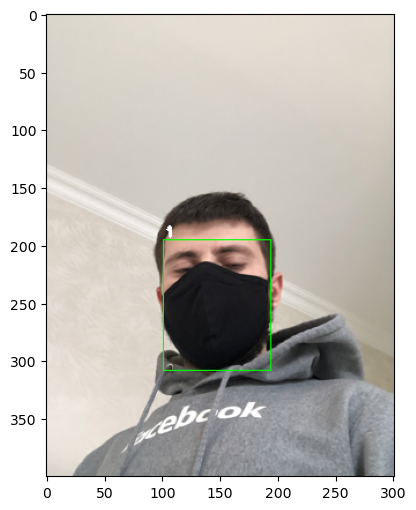

In [4]:
index = np.random.randint(0, len(datas))
img = cv2.imread(datas[index]['path'])
for (category, xmin, ymin, xmax, ymax) in datas[index]['objects']:
    # Draw bounding boxes
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
    cv2.putText(img, str(category), (xmin+2, ymin-3), cv2.FONT_HERSHEY_SIMPLEX, 0.38, (255,255,255), 2)
# Show image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
img_size = (100, 100)
X = []
Y = []

for data in datas:
    img = cv2.imread(data['path'])
    for (category, xmin, ymin, xmax, ymax) in data['objects']:
        roi = img[ymin : ymax, xmin : xmax]
        roi = cv2.resize(roi, (100, 100))
        data = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        target = to_categorical(category, num_classes=len(category2label))
        X.append(data)
        Y.append(target)
        
X = np.array(X)
Y = np.array(Y)

In [6]:
!ls

__notebook__.ipynb


In [7]:
os.makedirs('/kaggle/working/data')

In [8]:
np.save('/kaggle/working/data/X', X)
np.save('/kaggle/working/data/Y', Y)

In [9]:
with open('data/category2label.pkl', 'wb') as pf:
    pickle.dump(category2label, pf)

In [10]:
X = np.load('/kaggle/working/data/X.npy')
Y = np.load('/kaggle/working/data/Y.npy')

print(X.shape, Y.shape)

(4072, 100, 100, 3) (4072, 3)


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = X / 255.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=101)

In [13]:
X_train.shape, X_test.shape

((2850, 100, 100, 3), (1222, 100, 100, 3))

# Model Building

In [14]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [15]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [16]:
# base_model.summary()

In [17]:
for laye in base_model.layers:
    laye.trainable = False
    
# geting the last layer
last_layer = base_model.get_layer('mixed7')
last = last_layer.output

In [18]:
last_layer.name

'mixed7'

In [19]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [20]:
x = Flatten()(last)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
#The Final layer with 3 outputs for 3 categories
out = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs= out)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [21]:
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/data/model_{epoch:03d}.ckpt',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True, 
    verbose=0)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)

history = model.fit(X_train, 
                    Y_train, 
                    epochs=25, 
                    callbacks=[checkpoint,early_stop], 
                    validation_split=0.3)

Epoch 1/25
63/63 [==============================] - 14s 79ms/step - loss: 0.4675 - acc: 0.9087 - val_loss: 0.1893 - val_acc: 0.9369
Epoch 2/25
63/63 [==============================] - 2s 28ms/step - loss: 0.1186 - acc: 0.9574 - val_loss: 0.2548 - val_acc: 0.9322
Epoch 3/25
63/63 [==============================] - 2s 37ms/step - loss: 0.0940 - acc: 0.9714 - val_loss: 0.2599 - val_acc: 0.9428
Epoch 4/25
63/63 [==============================] - 2s 28ms/step - loss: 0.0534 - acc: 0.9845 - val_loss: 0.3513 - val_acc: 0.9241


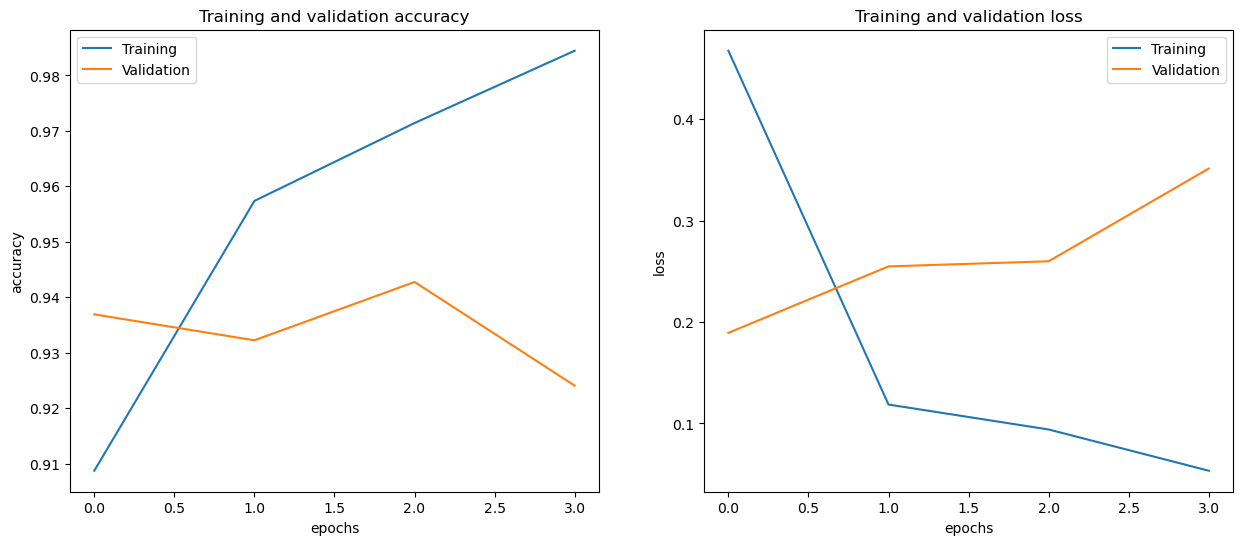

In [23]:
# PLOT LOSS AND ACCURACY
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluation

In [24]:
model.evaluate(X_test, Y_test)


39/39 [==============================] - 1s 20ms/step - loss: 0.1920 - acc: 0.9411


[0.19203411042690277, 0.9410802125930786]

In [25]:
import seaborn as sns

39/39 [==============================] - 2s 15ms/step


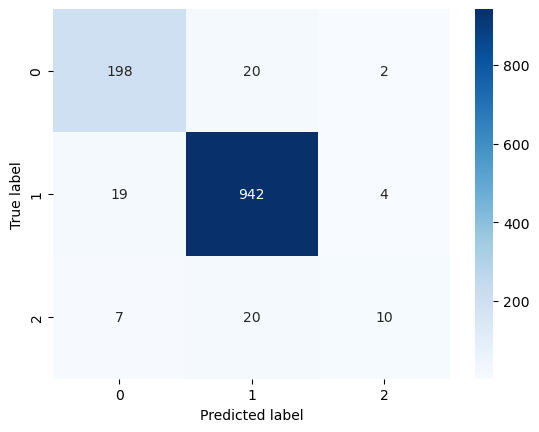

In [26]:
Y_pred = np.argmax(model.predict(X_test), axis=1)
Y_test = np.argmax(Y_test, axis=1)
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [27]:
model.save('/kaggle/working/data/mymodel.h5')

In [28]:
!ls $"/kaggle/working/data"

X.npy				    model_001.ckpt.index
Y.npy				    model_003.ckpt.data-00000-of-00001
category2label.pkl		    model_003.ckpt.index
checkpoint			    mymodel.h5
model_001.ckpt.data-00000-of-00001
